**Project for Algorithms for Massive Data (Prof. Malchiodi)**
</br>**Studnet: Shihab Hamati**
</br>**May 2023**

**Convolutional Neural Network to classify healthy plant leaves**

In [1]:
from google.colab import files
import os
import shutil
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Upload Kaggle Credentials JSON File
kaggle_token = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

Download dataset and unzip

In [4]:
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.55G/6.56G [01:29<00:00, 150MB/s]
100% 6.56G/6.56G [01:29<00:00, 78.3MB/s]


In [5]:
!unzip -q /content/plant-leaves-for-image-classification.zip

Generate list of subdirectories of diseased leaves

In [6]:
paths = ["/content/Plants_2/train", "/content/Plants_2/valid", "/content/Plants_2/test"]

Delete diseased folders, keep only health folders

In [7]:
def del_subdirs(path, keyword):
  paths_to_delete = [sd for sd in os.listdir(path) if keyword in sd]
  for p2d in paths_to_delete:
    shutil.rmtree(os.path.join(path, p2d))
  return

In [8]:
for p in paths:
  del_subdirs(p, 'diseased')

In [9]:
IMG_SIZE = (256,256)
RESCALE_FACTOR = 1.0/255
BATCH_SIZE = 32
SEED = 123

In [10]:
# Image Data Generator for training & validation datasets
# Applying data augmentation
gen_train_val = ImageDataGenerator(
    validation_split = 0.2,
    rescale = RESCALE_FACTOR,
    #width_shift_range = 0.1,
    #height_shift_range = 0.1,
    #shear_range = 0.1,
    #zoom_range = 0.1,
    horizontal_flip = True,
    #vertical_flip = True
    )     

In [11]:
# Image Data Generator for testing dataset
gen_test = ImageDataGenerator(rescale = RESCALE_FACTOR)

In [12]:
dataset_train = gen_train_val.flow_from_directory(
    directory=paths[0],
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    subset = "training",
    seed = SEED )

Found 1736 images belonging to 11 classes.


In [13]:
# only 55 images in the original valid folder, so split from the training folder instead
dataset_val = gen_train_val.flow_from_directory(
    directory = paths[0], # using the larger train folder
    target_size = IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = True,
    subset = "validation", 
    seed = SEED )

Found 427 images belonging to 11 classes.


In [14]:
dataset_test = gen_test.flow_from_directory(
    directory = paths[2],
    target_size = IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = False,
    seed = SEED )

Found 55 images belonging to 11 classes.


**CNN Model**

In [15]:
# Default params for create_cnn function
NUM_CLASSES=dataset_train.num_classes
INPUT_SHAPE = IMG_SIZE + (3,)

General function to create a CNN multi-class classifier
* Assumes more than 2 classes
* Allows to adapt number of convolutional layers
* Easy to experiment different architechtures rapidly and clearly


In [16]:
def create_cnn(conv_layers, dense_units, dropout=0, num_classes=NUM_CLASSES, input_shape=INPUT_SHAPE):
  """
  Create CNN with general arch of:
    A- Sequential Convolutional-ReLu-MaxPooling Layers >=1 of Doubling Num of Filters
    B- Dense Layers at the end of the convolutional sequence
    C- An Output Layer with Nodes = num_classes > 2
  """

  classifier = Sequential()

  # Initial Convolutional Block
  classifier.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    input_shape=input_shape,
    activation="relu")
  )

  classifier.add(MaxPooling2D(pool_size=(2, 2)))

  #classifier.add(Dropout(rate=0.2))

  # Additional Convolutional Block with twice the num of filters as previous block
  for cl in range(conv_layers-1):
    # when cl = 0, power = 6, so 2^6 = 64 (since initial layer has 32 filters)
    power = 6 + cl

    classifier.add(Conv2D(
      filters=2 ** power,
      kernel_size=(3, 3),
      padding="same",
      activation="relu")
    )

    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    if dropout>0:
      classifier.add(Dropout(rate=dropout))

  classifier.add(Flatten())

  # Dense Layers
  classifier.add(Dense(units=dense_units, activation="relu"))
    
  if dropout>0:
    classifier.add(Dropout(rate=dropout))

  # Output Layer
  classifier.add(Dense(units=num_classes, activation="softmax"))

  return classifier

In [17]:
model_1 = create_cnn(conv_layers = 4, dense_units = 32, dropout = 0.25)
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       7

In [18]:
EPOCHS = 25

In [19]:
!mkdir Checkpoints

In [20]:
cb_checkpoint = ModelCheckpoint("./Checkpoints/epoch_{epoch}.h5")
cb_earlystop = EarlyStopping(monitor='val_loss', 
                             patience=5, 
                             verbose=0, 
                             restore_best_weights=True,
                             start_from_epoch=10)

In [21]:
callbacks = [cb_checkpoint, cb_earlystop]
model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
model_1.load_weights("epoch_23.h5")

In [23]:
history = model_1.fit(dataset_train, epochs=EPOCHS, callbacks=callbacks, validation_data=dataset_val)

Epoch 1/25
55/55 [==============================] - 697s 12s/step - loss: 0.5761 - accuracy: 0.7909 - val_loss: 0.6312 - val_accuracy: 0.8009
Epoch 2/25
55/55 [==============================] - 633s 12s/step - loss: 0.5975 - accuracy: 0.7765 - val_loss: 0.9226 - val_accuracy: 0.6674
Epoch 3/25
55/55 [==============================] - 630s 11s/step - loss: 0.5847 - accuracy: 0.7909 - val_loss: 0.8739 - val_accuracy: 0.7775
Epoch 4/25
55/55 [==============================] - 656s 12s/step - loss: 0.5492 - accuracy: 0.8036 - val_loss: 0.6137 - val_accuracy: 0.8267
Epoch 5/25
55/55 [==============================] - 652s 12s/step - loss: 0.4949 - accuracy: 0.8059 - val_loss: 0.8073 - val_accuracy: 0.7260
Epoch 6/25
55/55 [==============================] - 630s 12s/step - loss: 0.5285 - accuracy: 0.8076 - val_loss: 1.1308 - val_accuracy: 0.7026
Epoch 7/25
55/55 [==============================] - 636s 12s/step - loss: 0.4916 - accuracy: 0.8283 - val_loss: 0.7267 - val_accuracy: 0.7892
Epoch 

In [24]:
model_1.evaluate(dataset_val)

14/14 [==============================] - 124s 9s/step - loss: 0.7072 - accuracy: 0.8126


[0.7072312235832214, 0.8126463890075684]

In [25]:
model_1.save_weights("model_1_earlystop.h5")

In [27]:
results = model_1.evaluate(dataset_test)
print("Loss: "+str(results[0])+" Accuracy: " + str(results[1]))

2/2 [==============================] - 19s 7s/step - loss: 0.9723 - accuracy: 0.8000
Loss: 0.9723005294799805 Accuracy: 0.800000011920929


Result after 41 epochs of training (23 + 18, early stopped) </br>
Previous notebook's runtime was disconnected by Colab, but the model weights were saved as checkpoints at each stage and download, and so the current notebook starting with the previous epoch 23 weights.

**Save Model Weights & Training History**

In [26]:
import numpy as np
np.save("trainingHist.npy",history)

**Plot Training and Validation Results**

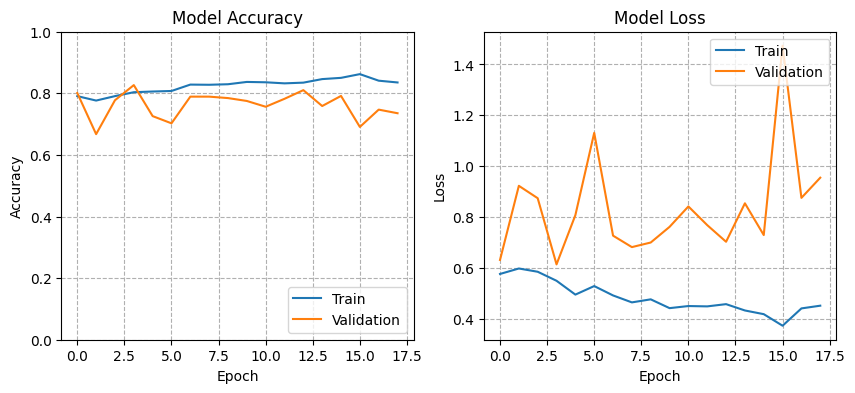

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()